# Comparison between different implementations for applying filter to a 3D volume

methods:
- Iterative mycarta's original implementation
- Vectorized Numpy
- Vecotrized Dask using numpy calls 
- Vecotrized Dask using dask calls 

In [1]:
from dask.distributed import Client # Used to create a LocalCluster on machine()
import numpy as np
from smallfoot import utils # holds tools

Hot reloading of libs mainly smallfoot

In [2]:
%load_ext autoreload
%autoreload 2

## Create the client cluster 

Here we create the dask cluster, using default params this can be played with but gives a good first approximation

In [3]:
Client()

Client Scheduler: tcp://127.0.0.1:44875 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 6 Memory: 17.18 GB


## Load in the data and create the filter

In [4]:
penobscot = np.load('images_and_data/penobscot.npy')
arr, _ = utils.pad_next_square_size(penobscot)

In [5]:
from skimage.draw import rectangle
from scipy import signal

def scipy_gaussian_2D(std):
    '''
    2D Gaussian filter kernel similar to astropy\'s Gaussian2DKernel
    (https://docs.astropy.org/en/stable/api/astropy.convolution.Gaussian2DKernel.html#astropy.convolution.Gaussian2DKernel)
    using scipy.signal.gaussian 
    (and inspired by https://gist.github.com/thomasaarholt/267ec4fff40ca9dff1106490ea3b7567)
    
    Parameters: 
    std (int) : standard deviation of the Gaussian in pixels
    
    Returns:
    out (2D array): 2D Gaussian filter kernel
    '''
    ksp1D = signal.gaussian(std*8+1, std)
    ksp2D = np.outer(ksp1D, ksp1D)
    ksp2D /= (2*np.pi*(std**2))
    return ksp2D

A = Ag = test1 = arr[:, :, 0]
rec= np.zeros(np.shape(A), dtype=np.uint8)
start1 = (np.shape(Ag)[0]//2+5,0)
end1 = (np.shape(Ag)[0]//2-5,np.shape(Ag)[0]//2-50)
rr1, cc1 = rectangle(start1, end=end1, shape=test1.shape)
rec[rr1, cc1] = 1

start2 = (np.shape(Ag)[0]//2+5,np.shape(Ag)[0]//2+50)
end2 = (np.shape(Ag)[0]//2-5,np.shape(Ag)[0]-1)
rr2, cc2 = rectangle(start2, end=end2, shape=test1.shape)
rec[rr2, cc2] = 1

gauss_kernel = scipy_gaussian_2D(11)
filter00 = signal.fftconvolve(rec, gauss_kernel, mode='same')
filter00 = utils.normalise(filter00)

# Comparison

In [6]:
%%timeit
utils.apply_filter_iterative(filter00, penobscot)

4.11 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
utils.apply_filter_iterative_pytorch(filter00, penobscot)

1.88 s ± 63.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
utils.apply_filter_iterative_pytorch(filter00, penobscot, cuda=True)

611 ms ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
utils.apply_filter_vector_pytorch(filter00, penobscot)

643 ms ± 58.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
utils.apply_filter_vector_pytorch(filter00, penobscot, cuda=True)

330 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
utils.apply_filter_vector(filter00, penobscot)

3.88 s ± 27.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
utils.apply_filter_vector_dask(filter00, penobscot).compute()

1.85 s ± 81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%timeit
utils.apply_filter_vector_dask_true(filter00, penobscot).compute()

1.91 s ± 87.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## testing the large data

In [15]:
!wget https://raw.githubusercontent.com/mycarta/t21-hack-footprint/UI-IN-OUT/dev/Example_Seismic_IN-OUT_using_segyio.ipynb

--2021-04-20 07:46:48--  https://raw.githubusercontent.com/mycarta/t21-hack-footprint/UI-IN-OUT/dev/Example_Seismic_IN-OUT_using_segyio.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4545 (4.4K) [text/plain]
Saving to: ‘Example_Seismic_IN-OUT_using_segyio.ipynb’

Example_Seismic_IN- 100%[===================>]   4.44K  --.-KB/s    in 0s      

2021-04-20 07:46:48 (46.8 MB/s) - ‘Example_Seismic_IN-OUT_using_segyio.ipynb’ saved [4545/4545]



In [21]:
!pip install pooch
!pip install segyio

     |████████████████████████████████| 90 kB 4.9 MB/s  eta 0:00:01


In [18]:
from pooch import retrieve

In [19]:
seismic_fname = retrieve(
    url="https://www.dropbox.com/s/seo668a3bssnrme/Penobscot_IL_1080-1540_XL_1020-1460_TWT_0-2500.sgy?raw=1",
    known_hash="ed69d5c06d8d97dd08e3435d6212188fdc9ab496853eed3737db686995131a42",
)

In [22]:
import segyio
with segyio.open(seismic_fname) as p:
    penobscot = segyio.cube(p)

In [23]:
print('Is inline the fast mode? ' + str(p.fast is p.iline))

Is inline the fast mode? True


In [24]:
np.shape(penobscot)

(461, 441, 626)

In [25]:
dim = np.shape(penobscot)
idx = np.arange(0, dim[0])
print(np.amin(idx), np.amax(idx))

lns = np.arange(np.amin(p.ilines), np.amax(p.ilines)+1)
print(np.amin(lns), np.amax(lns))

0 460
1080 1540


In [26]:
np.save('images_and_data/Penobscot_IL_1080-1540_XL_1020-1460_TWT_0-2500.npy', penobscot)

In [61]:
penobscot = np.load('images_and_data/Penobscot_IL_1080-1540_XL_1020-1460_TWT_0-2500.npy')


In [81]:
arr = utils.normalise(penobscot)

/home/jovyan/t21_footprint/t21-hack-footprint/smallfoot/utils.py:35: RuntimeWarning: invalid value encountered in true_divide
  return (arr - np.amin(arr, axis=(0, 1))) / (


In [29]:
filter00.shape

(461, 461)

In [64]:
print(penobscot.shape)
print(penobscot.min(),penobscot.max())

(461, 441, 626)
-32767.0 32766.0


In [82]:
print(arr.shape)
print(arr.min(),arr.max())

(461, 441, 626)
0.0 1.0


In [79]:
plt.i

In [32]:
%%timeit
utils.apply_filter_vector(filter00, penobscot)

33.5 s ± 1.65 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit
utils.apply_filter_vector_pytorch(filter00, penobscot)

5.82 s ± 252 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%%timeit
utils.apply_filter_vector_pytorch(filter00, penobscot, cuda=True)

2.83 s ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit
utils.apply_filter_vector_dask_true(filter00, penobscot).compute()

15.3 s ± 210 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%%timeit
utils.apply_filter_vector_dask_true(filter00, penobscot, chunk=50).compute()

14.9 s ± 261 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
out=utils.apply_filter_iterative_pytorch(filter00, arr, cuda=True)

In [99]:
out2=utils.apply_filter_vector_pytorch(filter00, arr)

torch.Size([461, 461, 1])
torch.Size([461, 461, 626])


In [42]:
import matplotlib.pyplot as plt

In [58]:
out.shape

(461, 441, 626)

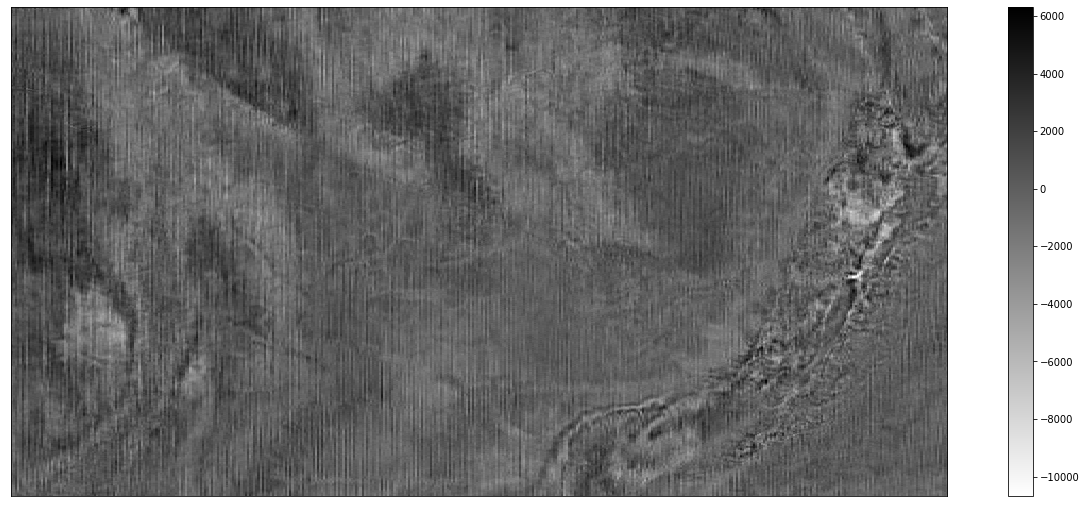

In [54]:
fig = plt.figure(figsize=(22, 9))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(penobscot[:,:,121], cmap='gray_r', aspect = 0.5, origin = 'lower', interpolation = 'none');  
# aspect = 0.5 since the Inline bin size is 12.5 m/line and the Crossline bin size is 25 m/line
plt.colorbar();

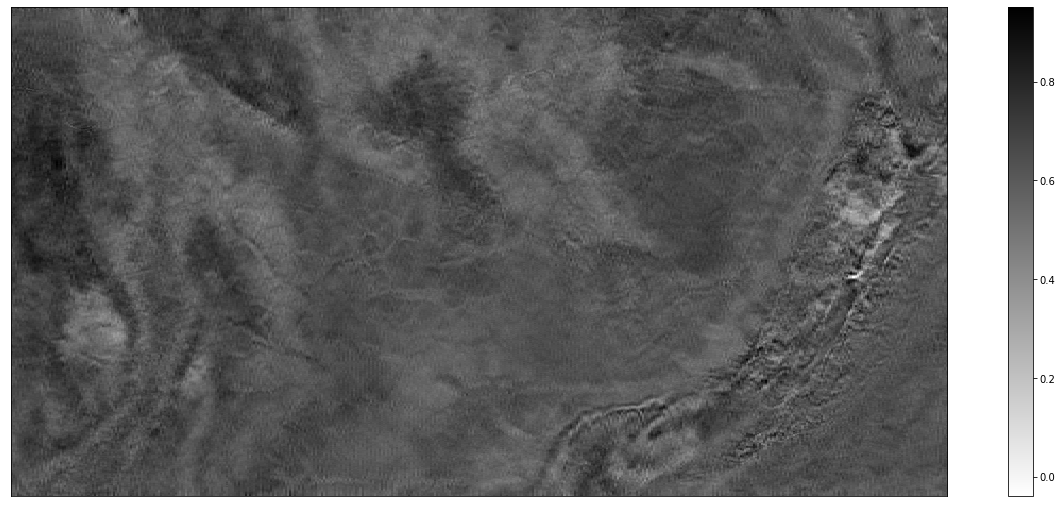

In [88]:
fig = plt.figure(figsize=(22, 9))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(out[:,:,121], cmap='gray_r', aspect = 0.5, origin = 'lower', interpolation = 'none');  
# aspect = 0.5 since the Inline bin size is 12.5 m/line and the Crossline bin size is 25 m/line
plt.colorbar();

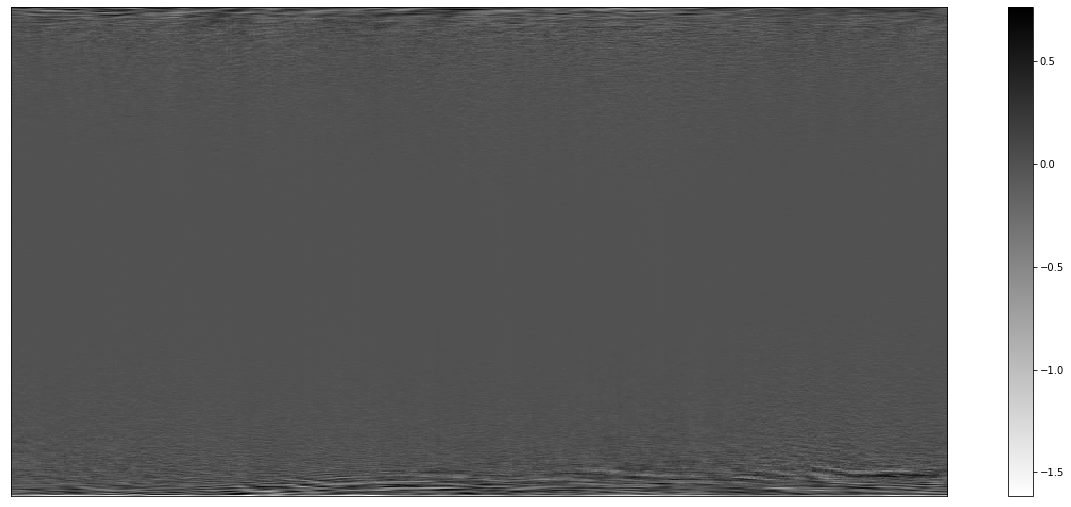

In [100]:
fig = plt.figure(figsize=(22, 9))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(out2[:,:,121], cmap='gray_r', aspect = 0.5, origin = 'lower', interpolation = 'none');  
# aspect = 0.5 since the Inline bin size is 12.5 m/line and the Crossline bin size is 25 m/line
plt.colorbar();